<a href="https://colab.research.google.com/github/teosantana/statsmodels/blob/main/Cluster_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install plotly
!pip install scipy
!pip install scikit-learn
!pip install pingouin




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 5.4 MB/s eta 0:00:00


In [2]:
#%% Importando os pacotes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
import scipy.stats as stats
from scipy.stats import zscore
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pingouin as pg
import plotly.express as px
import plotly.io as pio
pio.renderers.default='browser'



In [3]:
#%% Importando o banco de dados

# Objetivo: agrupar os clientes de uma operadora de cartão de crédito
# Analisar os grupos de clientes mais e menos leais à marca (por meio do uso)

dados_news_completo = pd.read_excel('noticias_fraude_corrupcao_bahia.xlsx')
dados_news_sem_nulos = dados_news_completo.dropna()
dados_news = dados_news_sem_nulos['municipios_citados']
dados_news_completo

,titulo,conteudo,fonte,datetime,link,img_url,palavra_chave,municipios_citados
0,Polícia Federal deflagra operação contra fraud...,Conteúdo não encontrado,GOV.BR,12/02/2025,https://news.google.com/./read/CBMiwwFBVV95cUx...,https://news.google.com/api/attachments/CC8iK0...,Fraude Licitação Bahia,NaN
1,Ex-prefeito de cidade da Bahia é condenado nov...,Conteúdo não encontrado,G1,14/03/2025,https://news.google.com/./read/CBMi4wFBVV95cUx...,https://news.google.com/api/attachments/CC8iK0...,Fraude Licitação Bahia,NaN
2,PF prende suspeitos de fraudes em licitações e...,Conteúdo não encontrado,Agência Brasil,23/12/2024,https://news.google.com/./read/CBMi1gFBVV95cUx...,https://news.google.com/api/attachments/CC8iK0...,Fraude Licitação Bahia,NaN
3,SJBA - Justiça Federal condena seis pessoas po...,Conteúdo não encontrado,TRF1,23/04/2025,https://news.google.com/./read/CBMi7gFBVV95cUx...,https://news.google.com/api/attachments/CC8iL0...,Fraude Licitação Bahia,Cansanção-2906808
4,Operação Overclean: Esquema criminoso em Campo...,Conteúdo não encontrado,Bahia Notícias,14/12/2024,https://news.google.com/./read/CBMi4wFBVV95cUx...,https://news.google.com/api/attachments/CC8iK0...,Fraude Licitação Bahia,Campo Formoso-2906006
...,...,...,...,...,...,...,...,...
1010,Justiça Federal condena ex-prefeito de Riacho ...,Conteúdo não encontrado,Agência Sertão,04/09/2019,https://news.google.com/./read/CBMi1AFBVV95cUx...,https://news.google.com/api/attachments/CC8iJ0...,Desvio Milionário Bahia,Riacho de Santana-2926400
1011,Operação Overclean: saiba quem são os presos e...,Conteúdo não encontrado,Farol da Bahia,11/12/2024,https://news.google.com/./read/CBMihAJBVV95cUx...,https://news.google.com/api/attachments/CC8iK0...,Desvio Milionário Bahia,NaN
1012,Caso 'Rei do Lixo': integrantes do judiciário ...,Conteúdo não encontrado,Farol da Bahia,29/01/2025,https://news.google.com/./read/CBMi4gFBVV95cUx...,https://news.google.com/api/attachments/CC8iK0...,Desvio Milionário Bahia,NaN
1013,Associações investigadas por fraude no INSS us...,Conteúdo não encontrado,Mídia Bahia,10/05/2025,https://news.google.com/./read/CBMi3AFBVV95cUx...,https://news.google.com/api/attachments/CC8iK0...,Desvio Milionário Bahia,NaN


In [4]:
# prompt: O conteúdo da lista contem o nome de municipio e o código IBGE deste município separado por '-'. separe os dois conteúdos e gere um dataframe com duas colunas.

import pandas as pd
# Lista de municípios e códigos IBGE
municipios_codigos = dados_news

# Crie listas para armazenar os nomes dos municípios e os códigos IBGE
nomes_municipios = []
codigos_ibge = []

# Itere sobre a lista e divida a string em nome e código
for item in municipios_codigos:
    if '-' in item:
        partes = item.split('-', 1) # Divide apenas no primeiro '-'
        nomes_municipios.append(partes[0].strip())
        codigos_ibge.append(partes[1].strip())

# Crie um DataFrame com as duas listas
df_municipios_ibge = pd.DataFrame({
    'municipio': nomes_municipios,
    'codigo_ibge': codigos_ibge
})

# Imprima o DataFrame resultante
print("\nDataFrame com nome do município e código IBGE:")
print(df_municipios_ibge.head())
df_municipios_ibge.info()
df_municipios_ibge.count()



DataFrame com nome do município e código IBGE:
       municipio codigo_ibge
0      Cansanção     2906808
1  Campo Formoso     2906006
2         Ilhéus     2913606
3      Cansanção     2906808
4       Camaçari     2905701
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   municipio    222 non-null    object
 1   codigo_ibge  222 non-null    object
dtypes: object(2)
memory usage: 3.6+ KB


,0
municipio,222
codigo_ibge,222


In [5]:
# prompt: troque as coluas de posicao mas mantenha a coluna codigo_ibge como inteiro

import pandas as pd
# Inverte a ordem das colunas
df_municipios_ibge = df_municipios_ibge[['codigo_ibge', 'municipio']]

# Converte a coluna 'codigo_ibge' para inteiro (tratando possíveis erros)
df_municipios_ibge['codigo_ibge'] = pd.to_numeric(df_municipios_ibge['codigo_ibge'], errors='coerce').astype('Int64')

# Imprime o DataFrame resultante com as colunas trocadas e o código IBGE como inteiro
print("\nDataFrame com colunas trocadas e código IBGE como inteiro:")
print(df_municipios_ibge.head())
print(df_municipios_ibge.info())


DataFrame com colunas trocadas e código IBGE como inteiro:
   codigo_ibge      municipio
0      2906808      Cansanção
1      2906006  Campo Formoso
2      2913606         Ilhéus
3      2906808      Cansanção
4      2905701       Camaçari
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   codigo_ibge  211 non-null    Int64 
 1   municipio    222 non-null    object
dtypes: Int64(1), object(1)
memory usage: 3.8+ KB
None


In [6]:
# prompt: agora crie outro dataframe com o código IBGE, nome do município e a quantidaade de ocorrências de cada município

# Contar a ocorrência de cada município
ocorrencias_por_municipio = df_municipios_ibge.groupby(['codigo_ibge', 'municipio']).size().reset_index(name='quantidade_ocorrencias')

# Criar o novo DataFrame
df_ocorrencias = ocorrencias_por_municipio

df_ocorrencias


,codigo_ibge,municipio,quantidade_ocorrencias
0,2901007,Amargosa,1
1,2901601,Antas,1
2,2902252,Arataca,1
3,2902708,Barra,3
4,2902906,Barra do Choça,1
...,...,...,...
76,2931400,Teodoro Sampaio,1
77,2931905,Tucano,1
78,2933174,Varzedo,2
79,2933307,Vitória da Conquista,11


In [9]:
# prompt: gerar um gráfico 2d usando o dataframe df_ocorrencias usando as colunas municipio e quantidade_ocorrencias ordenando pela quantidade_ocorrencias e exporte como html

# Ordenar o DataFrame pela quantidade de ocorrências
df_ocorrencias_sorted = df_ocorrencias.sort_values(by='quantidade_ocorrencias', ascending=False)

# Criar o gráfico de barras interativo
fig = px.bar(df_ocorrencias_sorted,
             x='municipio',
             y='quantidade_ocorrencias',
             title='Quantidade de Ocorrências por Município')

# Salvar o gráfico como arquivo HTML
fig.write_html("grafico_ocorrencias_municipios.html")

print("Gráfico gerado e salvo como grafico_ocorrencias_municipios.html")
#fig.show()


Gráfico gerado e salvo como grafico_ocorrencias_municipios.html


In [10]:
# prompt: agora pega do IBGE(requests.get("https://servicodados.ibge.gov.br/api/v1/localidades/estados/BA/municipios").json()) todos os municípios do estado da bahia com seu respectivo código IBGE

import pandas as pd
import requests

# Fazer a requisição para a API do IBGE
response = requests.get("https://servicodados.ibge.gov.br/api/v1/localidades/estados/BA/municipios")

# Verificar se a requisição foi bem sucedida
if response.status_code == 200:
    municipios_ibge_ba = response.json()

    # Criar um DataFrame com o nome do município e o código IBGE
    df_municipios_ibge_api = pd.DataFrame(municipios_ibge_ba)

    # Selecionar apenas as colunas 'id' (código IBGE) e 'nome' (nome do município)
    df_municipios_ibge_api = df_municipios_ibge_api[['id', 'nome']]

    # Renomear as colunas para melhor clareza
    df_municipios_ibge_api.rename(columns={'id': 'codigo_ibge', 'nome': 'municipio'}, inplace=True)

    # Imprimir o DataFrame resultante
    print("\nDataFrame com todos os municípios da Bahia e seus códigos IBGE (API do IBGE):")
    print(df_municipios_ibge_api.head())
    print("\n")
    print(df_municipios_ibge_api.info())

else:
    print(f"Erro ao obter dados da API do IBGE. Código de status: {response.status_code}")
    municipios_ibge_ba = None


DataFrame com todos os municípios da Bahia e seus códigos IBGE (API do IBGE):
   codigo_ibge  municipio
0      2900108     Abaíra
1      2900207      Abaré
2      2900306  Acajutiba
3      2900355   Adustina
4      2900405  Água Fria


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417 entries, 0 to 416
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   codigo_ibge  417 non-null    int64 
 1   municipio    417 non-null    object
dtypes: int64(1), object(1)
memory usage: 6.6+ KB
None


In [11]:
# prompt: acrescentar a coluna quantidade_ocorrencias ao dataframe df_municipios_ibge_api e preencher com zeros

df_municipios_ibge_api['quantidade_ocorrencias'] = 0
print(df_municipios_ibge_api.info())
print(df_ocorrencias.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417 entries, 0 to 416
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   codigo_ibge             417 non-null    int64 
 1   municipio               417 non-null    object
 2   quantidade_ocorrencias  417 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 9.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   codigo_ibge             81 non-null     Int64 
 1   municipio               81 non-null     object
 2   quantidade_ocorrencias  81 non-null     int64 
dtypes: Int64(1), int64(1), object(1)
memory usage: 2.1+ KB
None


In [12]:
# prompt: faça um merge dos 2 dataframes  somando a quantidade de ocorrencias e depois transforme a quantidade de ocorrencias em int64

import pandas as pd
# Fazer o merge dos dois dataframes somando as quantidades de ocorrências
# Usamos um outer merge para manter todos os municípios da Bahia
df_merged = pd.merge(df_municipios_ibge_api, df_ocorrencias, on=['codigo_ibge', 'municipio'], how='left')

# Preencher os valores NaN em 'quantidade_ocorrencias_y' com 0
df_merged['quantidade_ocorrencias_y'] = df_merged['quantidade_ocorrencias_y'].fillna(0)

# Somar as colunas de quantidade de ocorrências
df_merged['quantidade_ocorrencias_total'] = df_merged['quantidade_ocorrencias_x'] + df_merged['quantidade_ocorrencias_y']

# Remover as colunas originais de quantidade de ocorrências
df_merged = df_merged.drop(columns=['quantidade_ocorrencias_x', 'quantidade_ocorrencias_y'])

# Renomear a coluna total para quantidade_ocorrencias
df_merged.rename(columns={'quantidade_ocorrencias_total': 'quantidade_ocorrencias'}, inplace=True)

# Transformar a quantidade de ocorrências em int64
df_merged['quantidade_ocorrencias'] = df_merged['quantidade_ocorrencias'].astype('int64')

# Imprimir o DataFrame resultante do merge
df_merged



DataFrame resultante do merge com a quantidade total de ocorrências:
   codigo_ibge  municipio  quantidade_ocorrencias
0      2900108     Abaíra                       0
1      2900207      Abaré                       0
2      2900306  Acajutiba                       0
3      2900355   Adustina                       0
4      2900405  Água Fria                       0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417 entries, 0 to 416
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   codigo_ibge             417 non-null    int64 
 1   municipio               417 non-null    object
 2   quantidade_ocorrencias  417 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 9.9+ KB
None


,codigo_ibge,municipio,quantidade_ocorrencias
0,2900108,Abaíra,0
1,2900207,Abaré,0
2,2900306,Acajutiba,0
3,2900355,Adustina,0
4,2900405,Água Fria,0
...,...,...,...
412,2933307,Vitória da Conquista,11
413,2933406,Wagner,4
414,2933455,Wanderley,0
415,2933505,Wenceslau Guimarães,0


Abrir os DataFrames das Matrizes de Risco (PJ e PF) do LabContas e Consolidar as quantidades de cada tipologia em cada município

In [13]:
# prompt: crie o dataframe df_Matriz_PF e copiar os dados do arquivo excel matriz_PF.xlsx

import pandas as pd
df_Matriz_PF = pd.read_excel('matriz_PF.xlsx')
df_Matriz_PF

,CPF,NOME_CREDOR,DATA_NASCIMENTO,IND_SEXO,CPF_MAE,NOME_MAE,CPF_PAI,NOME_PAI,COD_SIT_CADAST,SIT_CADAST,...,TFPF_07_01,TFPF_07_02,TFPF_07_03,TFPF_07_04,TFPF_07_05,TFPF_08_01,TFPF_08_02,TFPF_08_03,TFPF_08_04,TFPF_08_05
0,547652500,LUCINEIDE MARIA DE BARROS,1973-04-19,F,NaN,JULIA FERREIRA MATOS,NaN,GERALDO VICENTE BARROS,0.0,REGULAR,...,0,0,0,0,0,0,0,0,0,0
1,546918506,NELINIO DE JESUS SILVA,1981-08-30,M,NaN,LINDINALVA MARIA DE JESUS,NaN,JOSE CARLOS DA SILVA,0.0,REGULAR,...,0,0,0,0,0,0,0,0,0,0
2,575005505,FRED FABIANO NEVES DAVID,1981-05-31,M,NaN,MARINALVA NEVES PEREIRA DAVID,NaN,VALMIR CARNEIRO DAVID,4.0,PENDENTE DE REGULARIZACAO,...,0,0,0,0,0,0,0,0,0,0
3,2900314437,GIVANILDO DA SILVA VIEIRA,1978-11-17,M,NaN,MARIA DO SOCORRO DA SILVA VEIRA,NaN,JOSÉ JOÃO VIEIRA,0.0,REGULAR,...,0,0,0,0,0,0,0,0,0,0
4,8906142536,WARLEY OLIVEIRA SOARES,2001-05-06,M,NaN,DOMINGAS OLIVEIRA BRITO SOARES,NaN,CLEIDIVAN SOARES,0.0,REGULAR,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72728,63658560088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
72729,68177273833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
72730,65613775400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
72731,30407945660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# prompt: consolide as informações das colunas TFPF_01_01, TFPF_01_02, TFPF_01_03, TFPF_01_04, TFPF_02_01, TFPF_02_02, TFPF_02_03, TFPF_04_01, TFPF_05_01, TFPF_05_02, TFPF_05_03, TFPF_05_04, TFPF_05_05, TFPF_05_06, TFPF_05_07, TFPF_05_08, TFPF_05_09, TFPF_05_11, TFPF_06_01, TFPF_06_02, TFPF_06_03, TFPF_06_04, TFPF_07_01, TFPF_07_02, TFPF_07_03, TFPF_07_04, TFPF_07_05, TFPF_08_01, TFPF_08_02, TFPF_08_03, TFPF_08_04, TFPF_08_05  por COD_IBGE.

# Lista das colunas a serem consolidadas
colunas_consolidar = [
    'TFPF_01_01', 'TFPF_01_02', 'TFPF_01_03', 'TFPF_01_04',
    'TFPF_02_01', 'TFPF_02_02', 'TFPF_02_03',
    'TFPF_04_01',
    'TFPF_05_01', 'TFPF_05_02', 'TFPF_05_03', 'TFPF_05_04', 'TFPF_05_05', 'TFPF_05_06', 'TFPF_05_07', 'TFPF_05_08', 'TFPF_05_09', 'TFPF_05_11',
    'TFPF_06_01', 'TFPF_06_02', 'TFPF_06_03', 'TFPF_06_04',
    'TFPF_07_01', 'TFPF_07_02', 'TFPF_07_03', 'TFPF_07_04', 'TFPF_07_05',
    'TFPF_08_01', 'TFPF_08_02', 'TFPF_08_03', 'TFPF_08_04', 'TFPF_08_05'
]

# Agrupar por COD_IBGE e somar as colunas especificadas
df_consolidado_pf = df_Matriz_PF.groupby('COD_IBGE')[colunas_consolidar].sum().reset_index()


df_consolidado_pf


,COD_IBGE,TFPF_01_01,TFPF_01_02,TFPF_01_03,TFPF_01_04,TFPF_02_01,TFPF_02_02,TFPF_02_03,TFPF_04_01,TFPF_05_01,...,TFPF_07_01,TFPF_07_02,TFPF_07_03,TFPF_07_04,TFPF_07_05,TFPF_08_01,TFPF_08_02,TFPF_08_03,TFPF_08_04,TFPF_08_05
0,1100015.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1100023.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1100064.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1100080.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1100106.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260,5220454.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1261,5221403.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1262,5221551.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1263,5221858.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Fazer o Merge do dataframe de notícias com os consolidados de tipologias de pessoas físicas.


In [15]:
# prompt: altere o nome da coluna COD_IBGE do df_consolidado_pf para codigo_ibge e faça um merge de df_consolidado_pf com df_merged pelo codigo_ibge

import pandas as pd
df_consolidado_pf.rename(columns={'COD_IBGE': 'codigo_ibge'}, inplace=True)

df_PF = pd.merge(df_merged, df_consolidado_pf,  on='codigo_ibge', how='left')

df_PF

,codigo_ibge,municipio,quantidade_ocorrencias,TFPF_01_01,TFPF_01_02,TFPF_01_03,TFPF_01_04,TFPF_02_01,TFPF_02_02,TFPF_02_03,...,TFPF_07_01,TFPF_07_02,TFPF_07_03,TFPF_07_04,TFPF_07_05,TFPF_08_01,TFPF_08_02,TFPF_08_03,TFPF_08_04,TFPF_08_05
0,2900108,Abaíra,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,2900207,Abaré,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,2900306,Acajutiba,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,2900355,Adustina,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,2900405,Água Fria,0,0,0,0,0,0,0,0,...,0,0,0,0,0,4,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,2933307,Vitória da Conquista,11,0,0,0,0,2,0,0,...,1,0,0,0,0,27,7,2,4,0
413,2933406,Wagner,4,0,0,0,0,0,0,0,...,0,0,0,0,0,2,1,0,0,0
414,2933455,Wanderley,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,0,0,0,0
415,2933505,Wenceslau Guimarães,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0


Gerar os clusters

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
import scipy.stats as stats
from scipy.stats import zscore
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pingouin as pg
import plotly.express as px
import plotly.io as pio
pio.renderers.default='browser'


In [17]:
df_cluster = df_PF.drop(columns=['codigo_ibge', 'municipio'])
df_cluster


,quantidade_ocorrencias,TFPF_01_01,TFPF_01_02,TFPF_01_03,TFPF_01_04,TFPF_02_01,TFPF_02_02,TFPF_02_03,TFPF_04_01,TFPF_05_01,...,TFPF_07_01,TFPF_07_02,TFPF_07_03,TFPF_07_04,TFPF_07_05,TFPF_08_01,TFPF_08_02,TFPF_08_03,TFPF_08_04,TFPF_08_05
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,4,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,11,0,0,0,0,2,0,0,1,0,...,1,0,0,0,0,27,7,2,4,0
413,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,1,0,0,0
414,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,0,0,0,0
415,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0


In [ ]:


#df_cluster_forn_servidor = df_cluster[['TFPF_05_06','quantidade_ocorrencias']]
#df_cluster_forn_servidor

#%% Identificação da quantidade de clusters (Método Elbow)

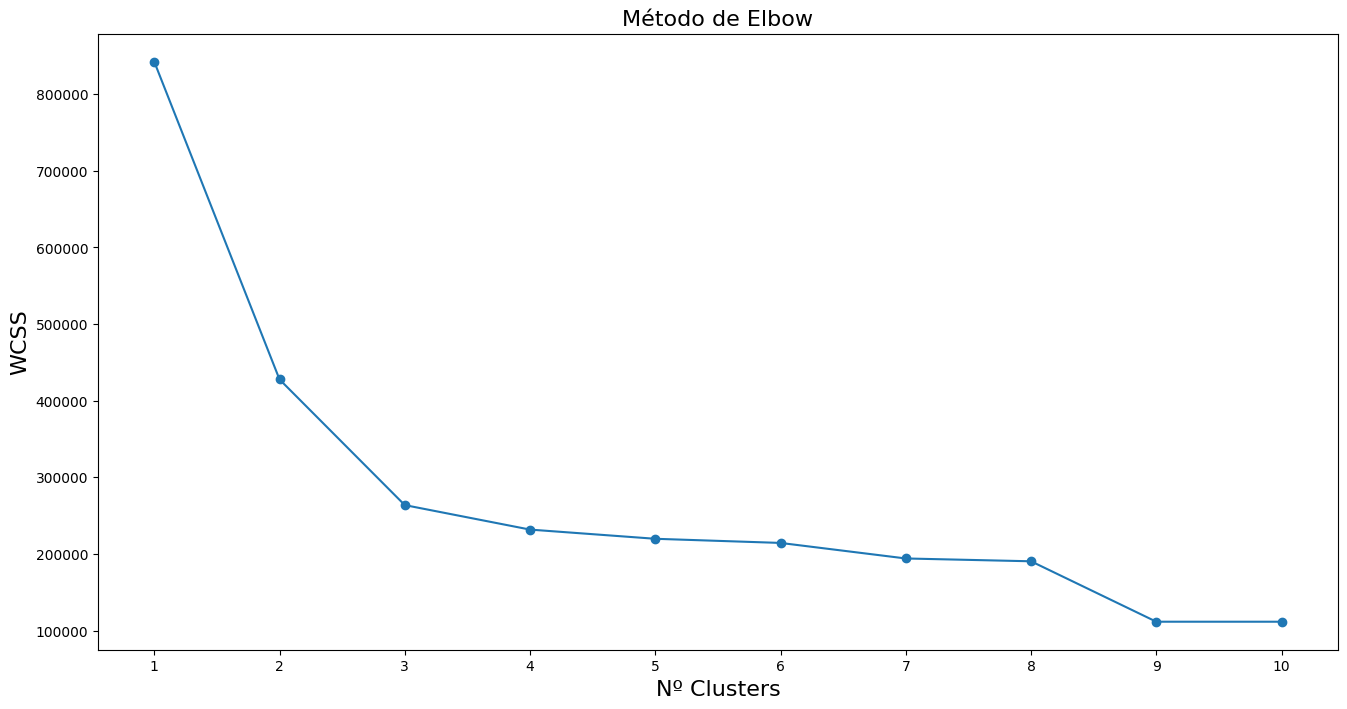

In [18]:
elbow = []
K = range(1,11) # ponto de parada pode ser parametrizado manualmente
for k in K:
    kmeanElbow = KMeans(n_clusters=k, init='random', random_state=100).fit(df_cluster)
    elbow.append(kmeanElbow.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, elbow, marker='o')
plt.xlabel('Nº Clusters', fontsize=16)
plt.xticks(range(1,11)) # ajustar range
plt.ylabel('WCSS', fontsize=16)
plt.title('Método de Elbow', fontsize=16)
plt.show()


Identificação da quantidade de clusters (Método Silhueta)

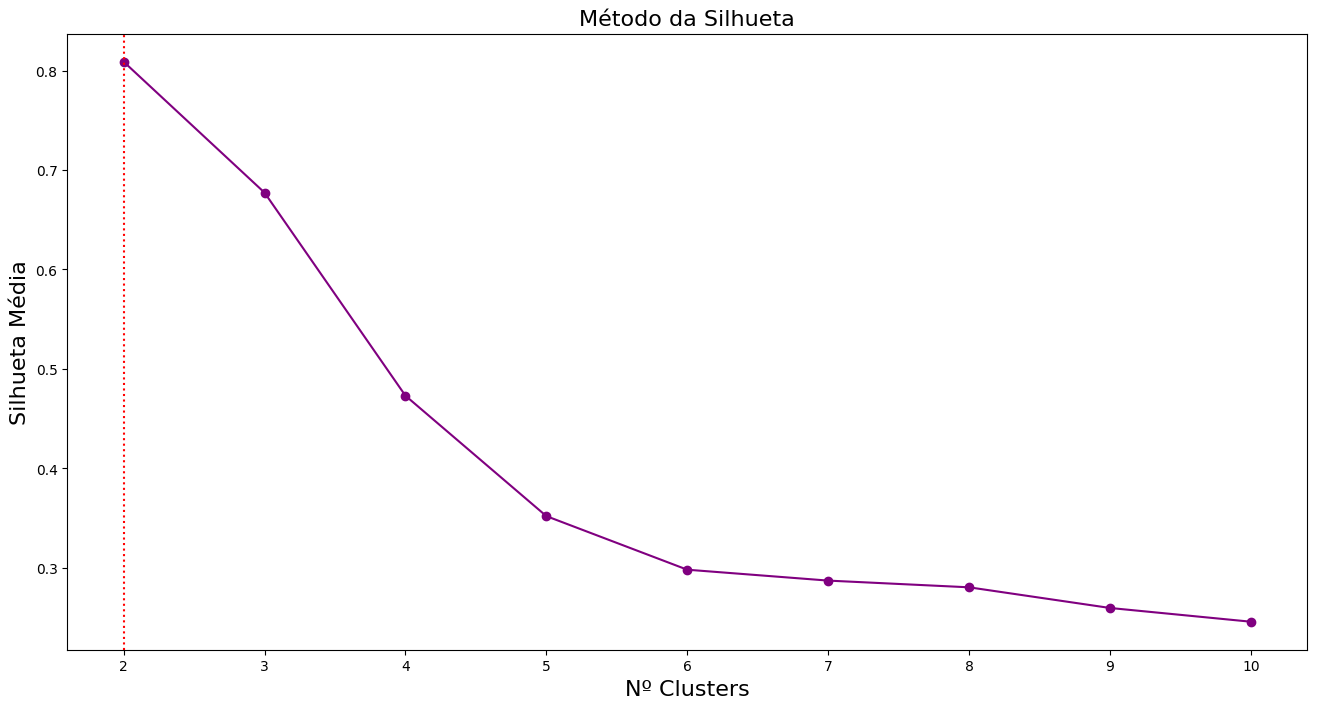

In [19]:

silhueta = []
I = range(2,11) # ponto de parada pode ser parametrizado manualmente
for i in I:
    kmeansSil = KMeans(n_clusters=i, init='random', random_state=100).fit(df_cluster)
    silhueta.append(silhouette_score(df_cluster, kmeansSil.labels_))

plt.figure(figsize=(16,8))
plt.plot(range(2, 11), silhueta, color = 'purple', marker='o')
plt.xlabel('Nº Clusters', fontsize=16)
plt.ylabel('Silhueta Média', fontsize=16)
plt.title('Método da Silhueta', fontsize=16)
plt.axvline(x = silhueta.index(max(silhueta))+2, linestyle = 'dotted', color = 'red')
plt.show()

Gerando o Cluster

In [20]:
#%% Cluster Não Hierárquico K-means

# Vamos considerar 2 clusters, considerando as evidências anteriores!

kmeans_final = KMeans(n_clusters = 2, init = 'random', random_state=100).fit(df_cluster)

# Gerando a variável para identificarmos os clusters gerados

PF_cluster = kmeans_final.labels_

df_cluster['cluster_kmeans'] = PF_cluster
df_PF['cluster_kmeans'] = PF_cluster

df_cluster['cluster_kmeans'] = df_cluster['cluster_kmeans'].astype('int64')
df_PF['cluster_kmeans'] = df_PF['cluster_kmeans'].astype('int64')

#df_cluster
df_PF[['municipio','quantidade_ocorrencias','cluster_kmeans']]


,municipio,quantidade_ocorrencias,cluster_kmeans
0,Abaíra,0,0
1,Abaré,0,0
2,Acajutiba,0,0
3,Adustina,0,0
4,Água Fria,0,0
...,...,...,...
412,Vitória da Conquista,11,1
413,Wagner,4,0
414,Wanderley,0,0
415,Wenceslau Guimarães,0,0


In [21]:
# prompt: imprima o dataframe df_PF exibindo os campos 'municipio','quantidade_ocorrencias','cluster_kmeans' nas primeiras colunas e as outras a seguir

df_PF[['municipio', 'quantidade_ocorrencias', 'cluster_kmeans']].join(df_PF.drop(columns=['municipio', 'quantidade_ocorrencias', 'cluster_kmeans']))

,municipio,quantidade_ocorrencias,cluster_kmeans,codigo_ibge,TFPF_01_01,TFPF_01_02,TFPF_01_03,TFPF_01_04,TFPF_02_01,TFPF_02_02,...,TFPF_07_01,TFPF_07_02,TFPF_07_03,TFPF_07_04,TFPF_07_05,TFPF_08_01,TFPF_08_02,TFPF_08_03,TFPF_08_04,TFPF_08_05
0,Abaíra,0,0,2900108,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,Abaré,0,0,2900207,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,Acajutiba,0,0,2900306,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,Adustina,0,0,2900355,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,Água Fria,0,0,2900405,0,0,0,0,0,0,...,0,0,0,0,0,4,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,Vitória da Conquista,11,1,2933307,0,0,0,0,2,0,...,1,0,0,0,0,27,7,2,4,0
413,Wagner,4,0,2933406,0,0,0,0,0,0,...,0,0,0,0,0,2,1,0,0,0
414,Wanderley,0,0,2933455,0,0,0,0,0,0,...,0,0,0,0,0,3,0,0,0,0
415,Wenceslau Guimarães,0,0,2933505,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0


In [22]:
# prompt: permita que o gráfico gerado acima gere um donwload interativo

# Gerar os clusters
pio.renderers.default = 'colab'

# Criar o gráfico interativo
fig = px.scatter_3d(df_PF,
                   x='municipio',
                   y='TFPF_05_06',
                   z='quantidade_ocorrencias',
                   hover_name='municipio',
                   color='cluster_kmeans', # Colorir os pontos com base no cluster
                   title='Gráfico 3D: Município, Cluster K-Means e Qtd. Notícias',
                   labels={'quantidade_ocorrencias': 'Qtd.Notícias','TFPF_05_06': 'Fornecedor Serv. Ativo'}) # Renomear o eixo Z



# Exibir o gráfico
fig.write_html("plotly_graph.html")
fig.show()

Gerar Cluster Hierárquico

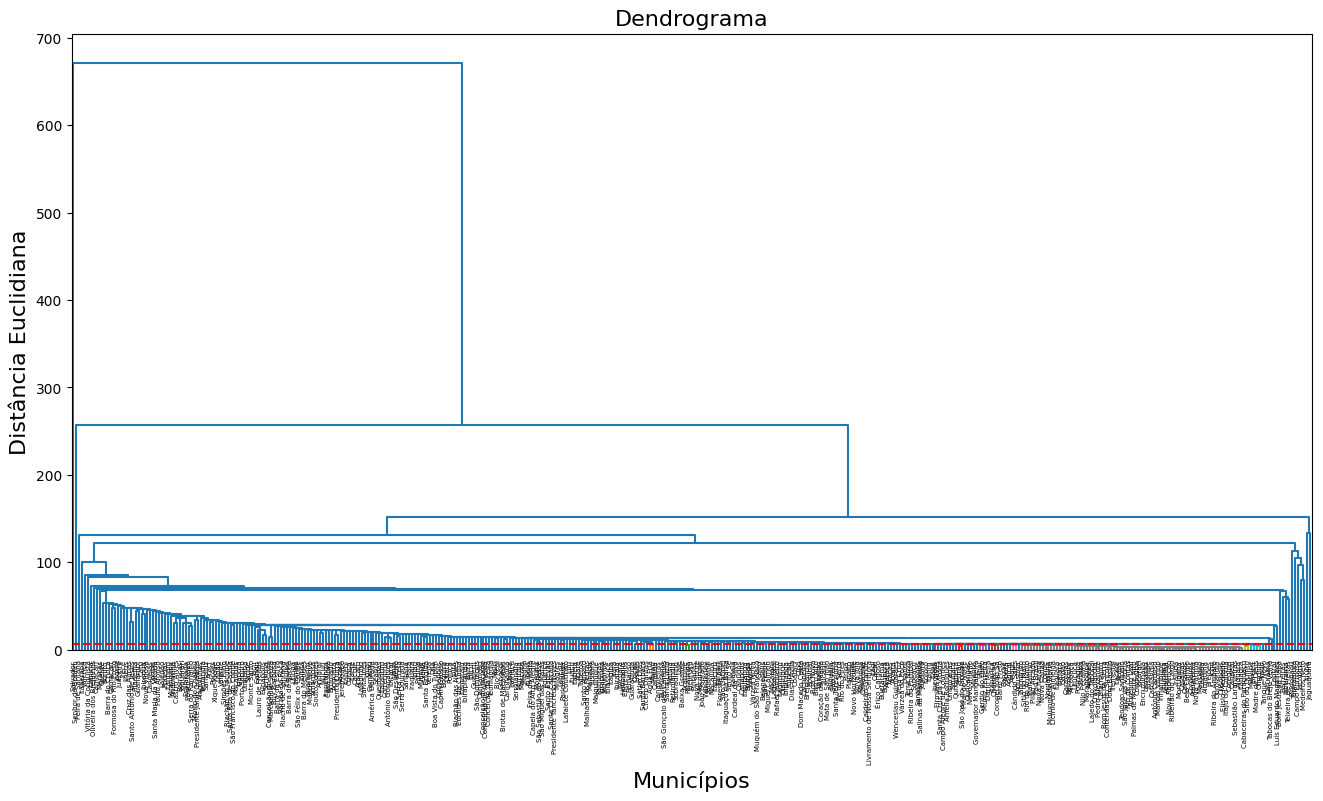

In [40]:
#%% Cluster hierárquico aglomerativo: distância euclidiana + single linkage

# Visualizando as distâncias
dist_euclidiana = pdist(df_cluster, metric='euclidean')

# Opções para as distâncias ("metric"):
    ## euclidean
    ## sqeuclidean
    ## cityblock
    ## chebyshev
    ## canberra
    ## correlation

# Gerando o dendrograma
## Distância euclidiana e método de encadeamento single linkage

plt.figure(figsize=(16,8))
dend_compl = sch.linkage(df_cluster, method = 'single', metric = 'cityblock')
dendrogram_c = sch.dendrogram(dend_compl, color_threshold = 6, labels = list(df_PF.municipio))
plt.title('Dendrograma', fontsize=16)
plt.xlabel('Municípios', fontsize=16)
plt.ylabel('Distância Euclidiana', fontsize=16)
plt.axhline(y = 6, color = 'red', linestyle = '--')
plt.show()

In [57]:


# Opções para o método de encadeamento ("method"):
    ## single
    ## complete
    ## average

# Opções para as distâncias ("metric"):
    ## euclidean
    ## sqeuclidean
    ## cityblock
    ## chebyshev
    ## canberra
    ## correlation

# Gerando a variável com a indicação do cluster no dataset

## Deve ser realizada a seguinte parametrização:
    ## Número de clusters (n_clusters)
    ## Medida de distância (metric)
    ## Método de encadeamento (linkage)

# Como já observamos 3 clusters no dendrograma, vamos selecionar "3" clusters
# A medida de distância e o método de encadeamento são mantidos

cluster_sing = AgglomerativeClustering(n_clusters = 4, metric = 'euclidean', linkage = 'complete')
indica_cluster_sing = cluster_sing.fit_predict(df_cluster)
df_PF['cluster_single'] = indica_cluster_sing
df_PF['cluster_single'] = df_PF['cluster_single'].astype('category')

# Coeficientes do esquema hierárquico de aglomeração (complete)
coef_single = [y[1] for y in dendrogram_c['dcoord']]
print(coef_single)

[np.float64(48.0), np.float64(32.0), np.float64(44.0), np.float64(41.0), np.float64(31.0), np.float64(27.0), np.float64(30.0), np.float64(31.0), np.float64(36.0), np.float64(36.0), np.float64(34.0), np.float64(32.0), np.float64(28.0), np.float64(30.0), np.float64(17.0), np.float64(23.0), np.float64(23.0), np.float64(26.0), np.float64(14.0), np.float64(19.0), np.float64(17.0), np.float64(19.0), np.float64(13.0), np.float64(15.0), np.float64(16.0), np.float64(14.0), np.float64(16.0), np.float64(14.0), np.float64(14.0), np.float64(14.0), np.float64(14.0), np.float64(13.0), np.float64(13.0), np.float64(12.0), np.float64(9.0), np.float64(11.0), np.float64(11.0), np.float64(10.0), np.float64(9.0), np.float64(10.0), np.float64(7.0), np.float64(10.0), np.float64(10.0), np.float64(5.0), np.float64(9.0), np.float64(9.0), np.float64(10.0), np.float64(9.0), np.float64(5.0), np.float64(7.0), np.float64(9.0), np.float64(9.0), np.float64(9.0), np.float64(9.0), np.float64(8.0), np.float64(8.0), np.flo

In [59]:
# prompt: permita que o gráfico gerado gere um donwload interativo

# Gerar os clusters
pio.renderers.default = 'colab'

# Criar o gráfico interativo
fig = px.scatter_3d(df_PF,
                   x='municipio',
                   y='TFPF_05_06',
                   z='quantidade_ocorrencias',
                   hover_name='municipio',
                   color='cluster_single', # Colorir os pontos com base no cluster
                   title='Gráfico 3D: Município, hierárquico aglomerativo: distância euclidiana + complete linkage',
                   labels={'quantidade_ocorrencias': 'Qtd.Notícias','TFPF_05_06': 'Fornecedor Serv. Ativo'}) # Renomear o eixo Z



# Exibir o gráfico
fig.write_html("plotly_hierarquico.html")
fig.show()